In [1]:
import random
import time
from uxsim import *
from IPython.display import display, Image

C:\Users\nanem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize simulation world
W = World(
    name="ddos_demo",  # Scenario name
    deltan=5,  # Simulation aggregation unit
    tmax=1200,  # Total simulation time
    print_mode=1,  # Print simulation progress
    save_mode=1,  # Save results
    show_mode=1,  # Show visualization
    random_seed=0  # Set random seed for repeatability
)


In [3]:
# Create nodes
W.addNode("orig1", 0, 0)
W.addNode("orig2", 0, 2)
node_signal = W.addNode("merge", 1, 1, signal=[30, 60])  # Add signal phases
W.addNode("dest", 2, 1)

# Add links and assign signal groups for dynamic traffic light
W.addLink("link1", "orig1", "merge", length=1000, free_flow_speed=20,
          number_of_lanes=1, merge_priority=0.5, signal_group=0)
W.addLink("link2", "orig2", "merge", length=1000, free_flow_speed=20,
          number_of_lanes=1, merge_priority=2, signal_group=1)
W.addLink("link3", "merge", "dest", length=1000, free_flow_speed=20,
          number_of_lanes=1)

# Define demand
W.adddemand("orig1", "dest", 0, 1000, 1)
W.adddemand("orig2", "dest", 500, 1000, 2)

In [6]:
# DDoS Red Agent Simulation: Flooding with irrelevant requests
def red_agent_ddos():
    """Simulate a DDoS attack by flooding the system with fake requests."""
    if int(W.TIME) % 50 == 0:  # Every 50 seconds simulate a DDoS attack
        num_requests = random.randint(10, 100)  # Simulate a random number of fake requests
        for _ in range(num_requests):
            random_link = random.choice(list(W.LINKS))  # Correctly pick a random link from LINK values
            random_phase = random.choice([0, 1])  # Randomly pick a signal phase (0 or 1)

            # Simulating DDoS: Randomly assign the signal group phase to disrupt normal flow
            if hasattr(random_link, 'signal_group'):
                random_link.signal_group = random_phase  # Alter signal group phase

            print(
                f"Red agent DDoS at t = {W.TIME}: Attacking signal phase on {random_link.name}, new phase = {random_phase}")

In [16]:
# Correction des signal_group
for link in W.LINKS:
    if hasattr(link, 'signal_group') and isinstance(link.signal_group, int):
        link.signal_group = [link.signal_group]

# Simulation en pas de temps
while W.check_simulation_ongoing():
    W.exec_simulation(duration_t2=10.0)
    red_agent_ddos()
    if int(W.TIME) % 100 == 0:
        print(f"t = {W.TIME} s; Signal phase = {node_signal.signal_phase}")


 generating animation...


100%|██████████| 120/120 [00:05<00:00, 20.47it/s]


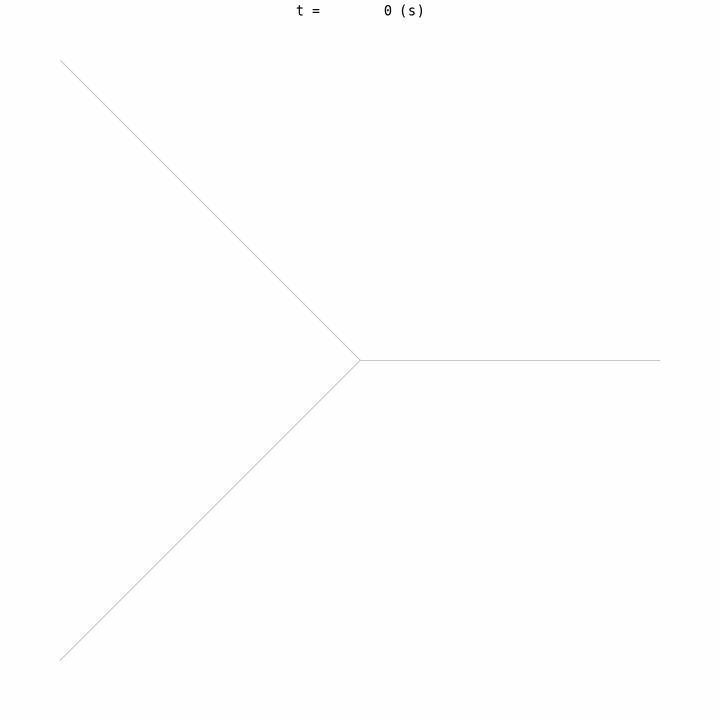

In [22]:
# Normal simulation without DDoS
while W_no_ddos.check_simulation_ongoing():
    W.exec_simulation(duration_t2=float(10))  # Advance simulation by 10s

    # DDoS attack initiated by the red agent
    red_agent_ddos()

    # Display simulation status every 100 seconds
    if int(W.TIME) % 100 == 0:
        print(f"t = {W.TIME} s; Signal phase = {node_signal.signal_phase}")

# Visualization
W.analyzer.network_fancy(animation_speed_inverse=15, sample_ratio=0.3,
                         interval=3, trace_length=3, network_font_size=0)

with open("outddos_demo/anim_network_fancy.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))

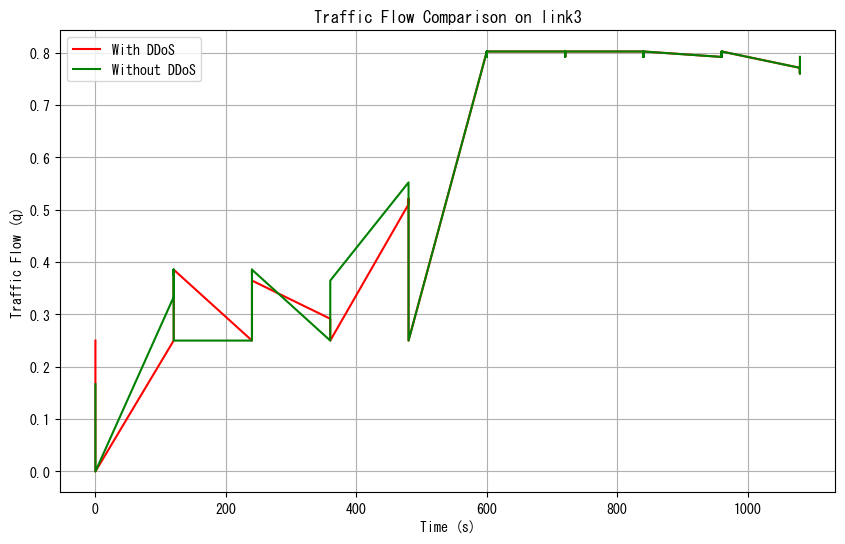

In [ ]:
# Normal simulation without DDoS
while W_no_ddos.check_simulation_ongoing():
    W_no_ddos.exec_simulation(duration_t2=10.0)  # Advance simulation by 10s

# Compare traffic data with and without DDoS
import matplotlib.pyplot as plt

# Plot traffic flow (q) over time for a specific link
link_to_compare = "link3"
traffic_ddos = traffic_with_ddos[traffic_with_ddos["link"] == link_to_compare]
traffic_no_ddos = traffic_without_ddos[traffic_without_ddos["link"] == link_to_compare]

plt.figure(figsize=(10, 6))
plt.plot(traffic_ddos["t"], traffic_ddos["q"], label="With DDoS", color="red")
plt.plot(traffic_no_ddos["t"], traffic_no_ddos["q"], label="Without DDoS", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Traffic Flow (q)")
plt.title(f"Traffic Flow Comparison)
plt.legend()
plt.grid()
plt.show()

In [14]:
# Export analysis data
display(W.analyzer.basic_to_pandas())
display(W.analyzer.od_to_pandas())
display(W.analyzer.mfd_to_pandas())
display(W.analyzer.link_to_pandas())
display(W.analyzer.link_traffic_state_to_pandas())
display(W.analyzer.vehicles_to_pandas())

W.analyzer.output_data()


,total_trips,completed_trips,total_travel_time,average_travel_time,total_delay,average_delay
0,2000,630,256650.0,407.380952,193650.0,307.380952


,orig,dest,total_trips,completed_trips,free_travel_time,average_travel_time,stddiv_travel_time,shortest_distance,average_distance_traveled_per_veh,stddiv_distance_traveled_per_veh
0,orig1,dest,1000,330,100.0,477.727273,223.537641,2000.0,913.5,952.446980
1,orig2,dest,1000,300,100.0,330.000000,131.177361,2000.0,810.0,971.197714


,t,network_k,network_q
0,0,0.015625,0.243403


,link,start_node,end_node,traffic_volume,vehicles_remain,free_travel_time,average_travel_time,stddiv_travel_time,length
0,link1,orig1,merge,350,140,50.0,436.375000,112.403593,1000
1,link2,orig2,merge,320,100,50.0,123.895833,71.677298,1000
2,link3,merge,dest,630,40,50.0,52.000000,2.653614,1000


,link,t,x,delta_t,delta_x,q,k,v
0,link1,0,0.0,120,100.0,0.770833,0.052604,14.653465
1,link1,0,100.0,120,100.0,0.739583,0.036979,20.000000
2,link1,0,200.0,120,100.0,0.708333,0.035417,20.000000
3,link1,0,300.0,120,100.0,0.666667,0.033333,20.000000
4,link1,0,400.0,120,100.0,0.635417,0.031771,20.000000
...,...,...,...,...,...,...,...,...
295,link3,1080,500.0,120,100.0,0.770833,0.038542,20.000000
296,link3,1080,600.0,120,100.0,0.770833,0.038542,20.000000
297,link3,1080,700.0,120,100.0,0.770833,0.038542,20.000000
298,link3,1080,800.0,120,100.0,0.760417,0.038021,20.000000


,name,dn,orig,dest,t,link,x,s,v
0,0,5,orig1,dest,5,link1,0.0,-1.0,20.0
1,0,5,orig1,dest,10,link1,100.0,-1.0,20.0
2,0,5,orig1,dest,15,link1,200.0,-1.0,20.0
3,0,5,orig1,dest,20,link1,300.0,-1.0,20.0
4,0,5,orig1,dest,25,link1,400.0,-1.0,20.0
...,...,...,...,...,...,...,...,...,...
35088,399,5,orig2,dest,1175,waiting_at_origin_node,-1.0,-1.0,-1.0
35089,399,5,orig2,dest,1180,waiting_at_origin_node,-1.0,-1.0,-1.0
35090,399,5,orig2,dest,1185,waiting_at_origin_node,-1.0,-1.0,-1.0
35091,399,5,orig2,dest,1190,waiting_at_origin_node,-1.0,-1.0,-1.0
